<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Implementing-EM-algorithm-for-MNIST-dataset" data-toc-modified-id="1.-Implementing-EM-algorithm-for-MNIST-dataset-1">1. Implementing EM algorithm for MNIST dataset</a></span><ul class="toc-item"><li><span><a href="#a.-Visualize-raw-data" data-toc-modified-id="a.-Visualize-raw-data-1.1">a. Visualize raw data</a></span></li><li><span><a href="#b.-Initialization-and-convergence" data-toc-modified-id="b.-Initialization-and-convergence-1.2">b. Initialization and convergence</a></span></li><li><span><a href="#c.-Fitted-GMM-model-and-mean-vectors" data-toc-modified-id="c.-Fitted-GMM-model-and-mean-vectors-1.3">c. Fitted GMM model and mean vectors</a></span></li><li><span><a href="#d.-GMM-vs.-K-means" data-toc-modified-id="d.-GMM-vs.-K-means-1.4">d. GMM vs. K-means</a></span></li></ul></li></ul></div>

# 1. Implementing EM algorithm for MNIST dataset

In [1]:
# Imports
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from scipy.io import loadmat

%matplotlib inline
np.random.seed(503)

In [2]:
# Load data and transpose
image_data = loadmat('data.mat')
print(f"Imported {image_data['data'].shape} array.")
images = image_data['data'].T

Imported (784, 1990) array.


In [3]:
num_images, num_pixels = images.shape
print(f"Images: {num_images}, pixels per image: {num_pixels}")

Images: 1990, pixels per image: 784


In [4]:
label_data = loadmat('label.mat')
print(f"Imported {label_data['trueLabel'].shape} array.")
labels = label_data['trueLabel'].T

Imported (1, 1990) array.


## a. Visualize raw data

In [5]:
image_side_length = int(np.sqrt(num_pixels))
print(f"Images are {image_side_length}x{image_side_length} pixels.")

Images are 28x28 pixels.


In [6]:
print(f"First 2: {[i for i, label in enumerate(labels.flatten().tolist()) if label == 2][0]}")
print(f"First 6: {[i for i, label in enumerate(labels.flatten().tolist()) if label == 6][0]}")

First 2: 0
First 6: 1032


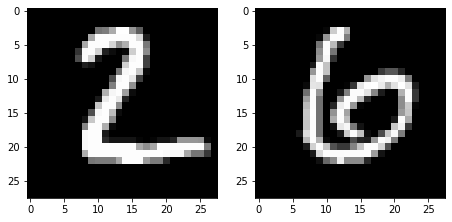

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.75))

# Visualize a "2"
ax[0].imshow(images[0].reshape((image_side_length, image_side_length), order='F'), cmap='gray')

# Visualize a "6"
ax[1].imshow(images[1032].reshape((image_side_length, image_side_length), order='F'), cmap='gray')

## b. Initialization and convergence

1. Initialize clusters (take two samples from a standard normal distribution for initial means $\mu$, and give each cluster/component a covariance matrix $\Sigma = I$ and $\pi = \frac{1}{2}$, assuming equal probability for each cluster to start)
2. Perform E-step:
   1. Compute $\mathrm{T} \in \mathbb{R}^{m \times k}$ matrix: probability of each point belonging to cluster $k$ given that cluster's $\pi$, $\mu$, and $\Sigma$
   2. Normalize $\mathrm{T}$ so that each column sums to 1
   
3. Perform M-step:
   1. For each cluster:
     1. Recompute cluster size $\pi$
     2. Recompute cluster mean $\mu$
     3. Recompute covariance matrix $\Sigma$     
     
4. Check for convergence and stop if convergence has been reached (when log-likelihood stops changing much):
   $$ log[p(X)] = \sum_i^m log\left[\sum_k^K \pi_k \mathcal{N}(x_i; \mu_k, \Sigma_k) \right] $$

For calculating probabilities in a multivariate Gaussian with high dimensionality, replace $\Sigma$ with $\tilde{\Sigma}$ (the low-rank approximation of $\Sigma$ per `speed-up-GMM.pdf`):
   $$ \mathcal{N}(x; \mu, \Sigma) \approx \frac{1}{\sqrt{(2\pi)^d \prod_{i=1}^{r} \lambda_i}} exp\left\{ -\frac{1}{2} \sum_{i=1}^{r} \frac{(\tilde{x}_i - \tilde{\mu}_i)^2}{\lambda_i} \right\} $$
   
   In the formula above, $det(\Sigma)$ is replaced by $det(\tilde{\Sigma}) = \prod_{i=1}^{r} \lambda_i$.

   The formula can also be written as:
   $$ \mathcal{N}(x; \mu, \Sigma) \approx \frac{exp\left\{ -\frac{1}{2} \sum_{i=1}^{r} \frac{(\tilde{x}_i - \tilde{\mu}_i)^2}{\lambda_i} \right\}}{\sqrt{(2\pi)^d \prod_{i=1}^{r} \lambda_i}} \approx \frac{exp\left\{ -\frac{1}{2} \sum_{i=1}^{r} \frac{(\tilde{x}_i - \tilde{\mu}_i)^2}{\lambda_i} \right\}}{\sqrt{(2\pi)^d} \cdot \sqrt{\prod_{i=1}^{r} \lambda_i}} $$
   
   Omitting the constant results in:
   $$ \mathcal{N}(x; \mu, \Sigma) \approx \frac{exp\left\{ -\frac{1}{2} \sum_{i=1}^{r} \frac{(\tilde{x}_i - \tilde{\mu}_i)^2}{\lambda_i} \right\}}{\sqrt{\prod_{i=1}^{r} \lambda_i}} $$
   
   Since $\sqrt{(2\pi)^d}$ is just a constant, we can eliminate that - it gets canceled out in the calculation for $\tau_{ik}$, and does not matter for the purpose of maximizing log-likelihood. This means we only need to calculate $\sqrt{\prod_{i=1}^r \lambda_i}$.

In [8]:
def initialize_clusters(K, m, d):    
    """Initializes cluster means as standard normals.
    
    Parameters
    ----------
    K : int
        The number of clusters.
    m : int
        The number of data points.
    d : int
        The number of dimensions/features.
        
    Returns
    -------
    Sigma : numpy array
        An array of initial covariance matrices (identity matrices) with shape (K, d, d).
    pi : numpy array
        An array of initial cluster sizes/mixing coefficients with shape (K, ).
    mu : numpy array
        An array of initial cluster mean vectors with shape (K, d).        
    """
    
    # Create K cluster means as random standard normals (centered around 0)
    mu = np.random.normal(loc=0, scale=1, size=(K, d))
    
    # Create K covariance matrices
    Sigma = np.repeat([np.identity(d)], K, axis=0)
    
    # Create pi array with all elements = 1/K
    pi = np.ones(K) / K
    
    return Sigma, pi, mu

In [9]:
def perform_E_step(X, Sigma, pi, mu, r=None):
    """Performs E-step of GMM. This uses the sped-up density calculation method.
    
    Parameters
    ----------
    X : numpy array
        An array of data in row format (features as column vectors) with shape (m, d).
    Sigma : numpy array
        An array of covariance matrices with shape (K, d, d).
    pi : numpy array
        An array of cluster sizes/mixing coefficients.
    mu : numpy array
        An array of cluster means with shape (K, d).
    r : int
        A rank r for approximating Sigma in order to efficiently calculate probabilities under a Gaussian
        distribution using the sped-up method.
    
    Returns
    -------
    Tau : numpy array
        An array of soft cluster assignments with shape (m, K).       
    """
    m, d = X.shape
    K = Sigma.shape[0]
    
    if r is None:
        r = d
        
    Tau = np.zeros((m, 2))  # Start with empty Tau    
        
    for k in range(K):  # For each cluster...
        # Eigendecomposition of Sigma, taking only the top r
        lam_approx, U_approx = linalg.eigh(Sigma[k], eigvals=(d-r, d-1))
        
        # Approximate data and means
        X_approx = (U_approx.T @ X.T).T  # Approximation of all the data
        mu_approx = U_approx.T @ mu[k].T  # Approximation of the current cluster's mean vector
                
        # Numerator of the density function (passed to exp as needed)
        normalized_distances_sq = -1/2 * np.sum(((X_approx - mu_approx)**2) / lam_approx, axis=1)

        # Denominator of the density function, with the constant removed
        lam_product_sqrt = np.sqrt(np.product(lam_approx))

        # Calculate density using rank-r approximations
        density = np.exp(normalized_distances_sq) / lam_product_sqrt

        # Calculate Tau
        Tau[:, k] = (pi[k] * density)
        
    # Normalize Tau to sum over 1
    Tau = Tau / np.sum(Tau, axis=1).reshape((m, 1))

    return Tau

In [10]:
def perform_M_step(X, Tau):
    """Performs M-step of GMM and updates the Sigma, pi, and mu parameters.
    
    Parameters
    ----------
    X : numpy array
        An array of data in row format (features as column vectors) with shape (m, d).
    Tau : numpy array
        An array of soft cluster assignments with shape (m, K).
    
    Returns
    -------
    Sigma : numpy array
        An array of covariance matrices with shape (K, d, d).
    pi : numpy array
        An array of cluster sizes/mixing coefficients.
    mu : numpy array
        An array of cluster means with shape (K, d).    
    """
    m, d = X.shape
    K = Tau.shape[1]
    
    Sigma = np.zeros((K, d, d))
    pi = np.ones(K) / K
    mu = np.zeros((K, d))
   
    for k in range(2):
        m_k = np.sum(Tau[:, k])
        pi[k] = m_k / m
        mu[k, :] = np.sum(Tau[:, k].reshape((m, 1)) * X, axis=0) / m_k
        Sigma[k, :, :] = ((Tau[:, k].reshape((m, 1)) * (X - mu[k, :])).T @ (X - mu[k, :])) / m_k

    return Sigma, pi, mu

In [11]:
def calculate_log_likelihood(X, Sigma, pi, mu, r=None):
    """Calculate log-likelihood of the whole model.
    
    Parameters
    ----------    
    X : numpy array
        An array of data in row format (features as column vectors) with shape (m, d).
    Sigma : numpy array
        An array of covariance matrices with shape (K, d, d).
    pi : numpy array
        An array of cluster sizes/mixing coefficients.
    mu : numpy array
        An array of cluster means with shape (K, d).
    r : int
        A rank r for approximating Sigma in order to efficiently calculate probabilities under a Gaussian
        distribution using the sped-up method.
    
    Returns
    -------
    log_likelihood : float
        The total log-likelihood of the model.
        This should be the sum over all points and clusters of log(pi_k * density).
    """
    m, d = X.shape
    K = Sigma.shape[0]
    
    if r is None:
        r = d
        
    weighted_densities = np.zeros((m, K))
               
    for k in range(K):  # For each cluster...
        # Eigendecomposition of Sigma, taking only the top r
        lam_approx, U_approx = linalg.eigh(Sigma[k], eigvals=(d-r, d-1))           
        
        # Approximate data and means
        X_approx = (U_approx.T @ X.T).T  # Approximation of all the data
        mu_approx = U_approx.T @ mu[k].T  # Approximation of the current cluster's mean vector
                
        # Numerator of the density function (passed to exp as needed)
        normalized_distances_sq = -1/2 * np.sum(((X_approx - mu_approx)**2) / lam_approx, axis=1)

        # Denominator of the density function, with the constant removed
        lam_product_sqrt = np.sqrt(np.product(lam_approx))
            
        # Calculate density using rank-r approximations
        density = np.exp(normalized_distances_sq) / lam_product_sqrt

        # Calculate Tau
        weighted_densities[:, k] = pi[k] * density
        
    log_likelihood = np.sum(weighted_densities, axis=1)  # Sum *for each data point* of weighted densities
    log_likelihood = np.sum(np.log(log_likelihood))  # Sum across all points of logged weighted densities
    
    return log_likelihood

In [12]:
def fit_GMM(X, K=2, r=10, iterations=25):
    """Fit a GMM model over a fixed number of iterations.
    
    Parameters
    ----------
    X : numpy array
        An array of data in row format (features as column vectors) with shape (m, d).
    K : int
        The number of components/clusters to fit.
    r : int
        A rank r for approximating Sigma in order to efficiently calculate probabilities under a Gaussian
        distribution using the sped-up method.
    iterations : int
        The number of iterations of EM to run when learning the parameters.
        
    Returns
    -------
    ll : list
        A list of log-likelihood scores.
    mu : numpy array
        An array of learned cluster means with shape (K, d).
    Tau : numpy array
        An array of soft cluster assignments with shape (m, K).
    pi : numpy array
        An array of cluster sizes/mixing coefficients.    
    """
    Sigma, pi, mu = initialize_clusters(K, X.shape[0], X.shape[1])
    
    ll = []

    for iteration in range(iterations):
        Tau = perform_E_step(X, Sigma, pi, mu, r=r)
        Sigma, pi, mu = perform_M_step(X, Tau)

        current_ll = calculate_log_likelihood(X, Sigma, pi, mu, r=r)
        
        ll.append(current_ll)

    return ll, mu, Tau, pi

In [13]:
# Fit GMM models with different values for r and extract parameters for parts c + d
lls = []
mus = []
Taus = []
pis = []

ll, mu, Tau, pi = fit_GMM(images, r=10)
lls.append(ll)
mus.append(mu)
Taus.append(Tau)
pis.append(pi)

ll, mu, Tau, pi = fit_GMM(images, r=20)
lls.append(ll)
mus.append(mu)
Taus.append(Tau)
pis.append(pi)

ll, mu, Tau, pi = fit_GMM(images, r=50)
lls.append(ll)
mus.append(mu)
Taus.append(Tau)
pis.append(pi)

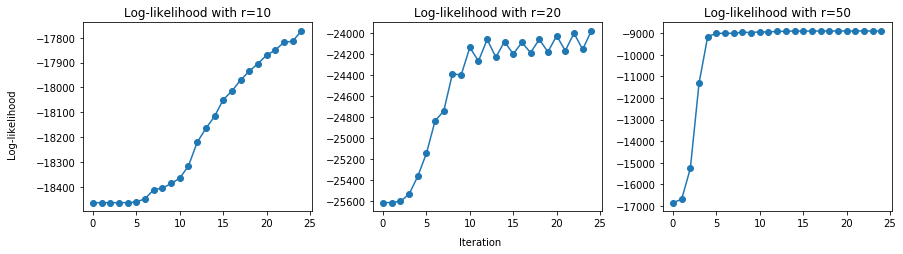

In [14]:
# Plot results
fig, ax = plt.subplots(1, 3, figsize=(12.5, 3.75), sharex=True)
fig.tight_layout(pad=3.0)

ax[0].plot(np.arange(25), lls[0], '-ok', color='#1f77b4')
ax[0].set_title("Log-likelihood with r=10")
ax[1].plot(np.arange(25), lls[1], '-ok', color='#1f77b4')
ax[1].set_title("Log-likelihood with r=20")
ax[2].plot(np.arange(25), lls[2], '-ok', color='#1f77b4')
ax[2].set_title("Log-likelihood with r=50")

fig.text(0.5, 0.05, 'Iteration', ha='center')
fig.text(-0.025, 0.5, 'Log-likelihood', va='center', rotation='vertical')

plt.show()

## c. Fitted GMM model and mean vectors

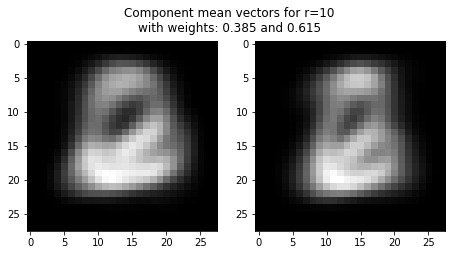

In [15]:
# Plot mean vectors for r=10
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.75))

ax[0].imshow(mus[0][0].reshape((image_side_length, image_side_length), order='F'), cmap='gray')
ax[1].imshow(mus[0][1].reshape((image_side_length, image_side_length), order='F'), cmap='gray')

fig.suptitle("Component mean vectors for r=10\nwith weights: {:.3f} and {:.3f}".format(pis[0][0], pis[0][1]))

plt.show()

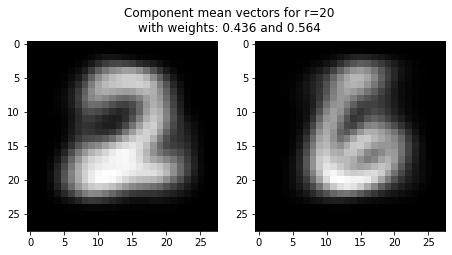

In [16]:
# Plot mean vectors for r=20
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.75))

# Note that random initialization means that for this trial, the "6" cluster had the index of 0 and not 1
ax[0].imshow(mus[1][1].reshape((image_side_length, image_side_length), order='F'), cmap='gray')
ax[1].imshow(mus[1][0].reshape((image_side_length, image_side_length), order='F'), cmap='gray')

fig.suptitle("Component mean vectors for r=20\nwith weights: {:.3f} and {:.3f}".format(pis[1][1], pis[1][0]))

plt.show()

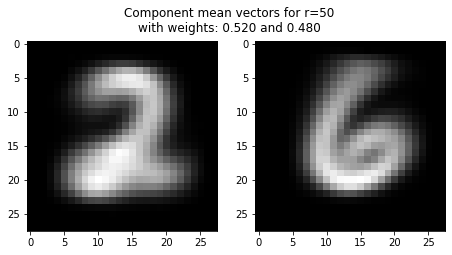

In [17]:
# Plot mean vectors for r=50
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.75))

ax[0].imshow(mus[2][0].reshape((image_side_length, image_side_length), order='F'), cmap='gray')
ax[1].imshow(mus[2][1].reshape((image_side_length, image_side_length), order='F'), cmap='gray')

fig.suptitle("Component mean vectors for r=50\nwith weights: {:.3f} and {:.3f}".format(pis[2][0], pis[2][1]))

plt.show()

## d. GMM vs. K-means

In [18]:
# Get the component IDs predicted by the final model with r=50 (the subjectively best model)
predicted_components = np.argmax(Taus[2], axis=1)
print(predicted_components)

[0 0 0 ... 1 1 1]


In [19]:
# Convert component IDs into image labels
predicted_labels = np.where(predicted_components == 0, 2, 6)
print(predicted_labels)

[2 2 2 ... 6 6 6]


In [20]:
# Get true labels into the same shape as the predicted labels array
true_labels = labels.flatten()
print(true_labels)

[2 2 2 ... 6 6 6]


In [21]:
# Get indices of data points that are actually "2"s and "6"s
ix_2s = true_labels == 2
ix_6s = true_labels == 6

In [22]:
# Calculate misclassification for "2"s
should_be_2s = predicted_labels[ix_2s]  # Subset of predictions that should be "2"s
true_2s = true_labels[ix_2s]
misclass_rate_2s = np.where(should_be_2s != true_2s)[0].shape[0] / images.shape[0]
print(f"GMM misclassification rate for \"2\"s: {misclass_rate_2s}")

GMM misclassification rate for "2"s: 0.009547738693467337


In [23]:
# Calculate misclassification for "6"s
should_be_6s = predicted_labels[ix_6s]  # Subset of predictions that should be "2"s
true_6s = true_labels[ix_6s]
misclass_rate_6s = np.where(should_be_6s != true_6s)[0].shape[0] / images.shape[0]
print(f"GMM misclassification rate for \"6\"s: {misclass_rate_6s}")

GMM misclassification rate for "6"s: 0.010552763819095477


In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=503).fit(images)

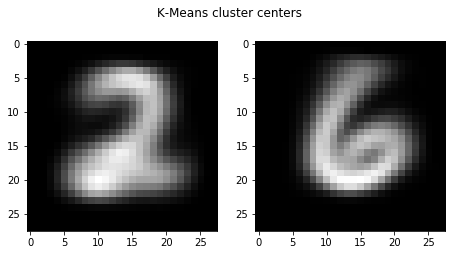

In [25]:
# Plot mean vectors for KMeans to identify which label corresponds to "2" vs. "6"
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.75))

# Cluster center order below ("2" vs. "6") determined empirically
ax[0].imshow(kmeans.cluster_centers_[1].reshape((image_side_length, image_side_length), order='F'), cmap='gray')
ax[1].imshow(kmeans.cluster_centers_[0].reshape((image_side_length, image_side_length), order='F'), cmap='gray')

fig.suptitle("K-Means cluster centers")

plt.show()

In [26]:
# Convert K-Means cluster indices into digit labels ("2" and "6")
# Indices determined empirically
predicted_labels = np.where(kmeans.labels_ == 1, 2, 6)
print(predicted_labels)

[2 2 2 ... 2 6 6]


In [27]:
# Calculate misclassification for "2"s
should_be_2s = predicted_labels[ix_2s]  # Subset of predictions that should be "2"s
true_2s = true_labels[ix_2s]
misclass_rate_2s = np.where(should_be_2s != true_2s)[0].shape[0] / images.shape[0]
print(f"K-Means misclassification rate for \"2\"s: {misclass_rate_2s}")

K-Means misclassification rate for "2"s: 0.02814070351758794


In [28]:
# Calculate misclassification for "6"s
should_be_6s = predicted_labels[ix_6s]  # Subset of predictions that should be "2"s
true_6s = true_labels[ix_6s]
misclass_rate_6s = np.where(should_be_6s != true_6s)[0].shape[0] / images.shape[0]
print(f"K-Means misclassification rate for \"6\"s: {misclass_rate_6s}")

K-Means misclassification rate for "6"s: 0.034170854271356785
